# Analysis & Feature Engineering
___

#### Analysis
* 1.1 Examining individual customer data
* 1.2 Spending effects on customer
* 1.3 Feature Examination

#### Feature Engineering
* 2.1 Encoding date of each event
* 2.2 Encoding past transaction features
* 2.3 Create last transaction and amount features
* 2.4 Create offer received, viewed and related spending features
* 2.5 Overlap offer effect
* 2.6 Mapping Events
* 2.7 Spending habits under offer influence
* 2.8 Time buckets
* 2.9 Various feature cleaning
* 2.10 Converting to numerical and NaN
* 2.11 Historical features
* 2.12 Label Encoding Categorical Features
* 2.13 Previous offer features
* 2.14 Column Ordering and dropping redundant features

#### Build Features
* 3.1 Building all features from scratch

## 1. Analysis
___

In order to make a predictive model, raw data needs to be cleaned and restructered in a tidy format. Each row must constitute a separate observation - in this case a specific offer received by a specific customer at a specific time. Within this observation we will need to embed customer behaviour/habits/tendancies which we can feature engineer based on past customer behaviour, e.g. spending habits, previous responses to offers.

In [224]:
# mount google drive if running in colab
import os
import sys

if os.path.exists('/usr/lib/python3.6/'):
    from google.colab import drive
    drive.mount('/content/drive/')
    sys.path.append('/content/drive/My Drive/Colab Notebooks/Starbucks_Udacity')
    %cd /content/drive/My Drive/Colab Notebooks/Starbucks_Udacity/notebooks/exploratory
else:
    sys.path.append('../../')

In [225]:
import numpy as np
import os
import pandas as pd
import joblib
import progressbar
import re
import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# importing scripts
%load_ext autoreload
%autoreload 2
%aimport src.data.make_dataset 
%aimport src.utilities.helper
%aimport src.features.build_features
from src.features.build_features import date_features
from src.data.make_dataset import save_file#

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
transcript = joblib.load('../../data/interim/transcript.joblib', mmap_mode=None)
transcript.head(10)

,offer_id,person,event,time,age,income,signed_up,F,M,O,amount,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,cum_amount,joined,offer received,offer viewed,offer completed,transaction
0,78afa995795e4d85b5d9ceeca43f5fefg1,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,75.0,100000.0,2017-05-09,1,0,0,0.00,g,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.00,-443,1,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fefg1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,75.0,100000.0,2017-05-09,1,0,0,0.00,g,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.00,-443,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef01,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,75.0,100000.0,2017-05-09,1,0,0,19.89,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.89,-443,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fefg1,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,75.0,100000.0,2017-05-09,1,0,0,0.00,g,5.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,19.89,-443,0,0,1,0
4,78afa995795e4d85b5d9ceeca43f5fef02,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,75.0,100000.0,2017-05-09,1,0,0,17.78,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.67,-443,0,0,0,1
5,78afa995795e4d85b5d9ceeca43f5fefj1,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,75.0,100000.0,2017-05-09,1,0,0,0.00,j,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,37.67,-443,1,0,0,0
6,78afa995795e4d85b5d9ceeca43f5fefj1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,75.0,100000.0,2017-05-09,1,0,0,0.00,j,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,37.67,-443,0,1,0,0
7,78afa995795e4d85b5d9ceeca43f5fef03,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,75.0,100000.0,2017-05-09,1,0,0,19.67,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.34,-443,0,0,0,1
8,78afa995795e4d85b5d9ceeca43f5fef04,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,75.0,100000.0,2017-05-09,1,0,0,29.72,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.06,-443,0,0,0,1
9,78afa995795e4d85b5d9ceeca43f5fef05,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,75.0,100000.0,2017-05-09,1,0,0,23.93,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.99,-443,0,0,0,1


### 1.1 Examining individual customer data

Currently the data is structered with each row representing an event:
* Offer received
* Offer viewed
* Transaction
* Offer completed

Taking a look at the data for the first person/customer:

In [173]:
def person_data(person):
    '''
    Displays unique customer's event history
    
    Parameters
    -----------
    person: if int then customer index as per the order in which 
    customer appears in transcript data, if string then person 
    referenced by their unique 'person' id           
    '''
    if type(person) == str:
        return transcript[transcript.person == person]
    return transcript[transcript.person == transcript.person.unique()[person]]

In [174]:
# Displaying event history of person 57 
# (person='fa7ccb17b2b14f32804d14f86ac87f04')
person_data(57)

,offer_id,person,event,time,age,income,signed_up,F,M,O,amount,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,cum_amount,joined,offer received,offer viewed,offer completed,transaction
1109,fa7ccb17b2b14f32804d14f86ac87f04e1,fa7ccb17b2b14f32804d14f86ac87f04,offer received,0,38.0,66000.0,2017-02-11,0,1,0,0.00,e,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.00,-530,1,0,0,0
1110,fa7ccb17b2b14f32804d14f86ac87f04e1,fa7ccb17b2b14f32804d14f86ac87f04,offer viewed,36,38.0,66000.0,2017-02-11,0,1,0,0.00,e,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.00,-530,0,1,0,0
1111,fa7ccb17b2b14f32804d14f86ac87f0401,fa7ccb17b2b14f32804d14f86ac87f04,transaction,48,38.0,66000.0,2017-02-11,0,1,0,3.38,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.38,-530,0,0,0,1
1112,fa7ccb17b2b14f32804d14f86ac87f0402,fa7ccb17b2b14f32804d14f86ac87f04,transaction,102,38.0,66000.0,2017-02-11,0,1,0,2.29,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.67,-530,0,0,0,1
1113,fa7ccb17b2b14f32804d14f86ac87f0403,fa7ccb17b2b14f32804d14f86ac87f04,transaction,156,38.0,66000.0,2017-02-11,0,1,0,12.05,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.72,-530,0,0,0,1
1114,fa7ccb17b2b14f32804d14f86ac87f04e1,fa7ccb17b2b14f32804d14f86ac87f04,offer completed,156,38.0,66000.0,2017-02-11,0,1,0,0.00,e,2.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,17.72,-530,0,0,1,0
1115,fa7ccb17b2b14f32804d14f86ac87f04a1,fa7ccb17b2b14f32804d14f86ac87f04,offer received,168,38.0,66000.0,2017-02-11,0,1,0,0.00,a,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,17.72,-530,1,0,0,0
1116,fa7ccb17b2b14f32804d14f86ac87f0404,fa7ccb17b2b14f32804d14f86ac87f04,transaction,240,38.0,66000.0,2017-02-11,0,1,0,3.58,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.30,-530,0,0,0,1
1117,fa7ccb17b2b14f32804d14f86ac87f0405,fa7ccb17b2b14f32804d14f86ac87f04,transaction,252,38.0,66000.0,2017-02-11,0,1,0,2.23,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.53,-530,0,0,0,1
1118,fa7ccb17b2b14f32804d14f86ac87f04g1,fa7ccb17b2b14f32804d14f86ac87f04,offer received,408,38.0,66000.0,2017-02-11,0,1,0,0.00,g,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,23.53,-530,1,0,0,0


Each person's data comprises of events through time measured in hours. As a type of time series problem we will need to extract features based on time.

In [175]:
# Converting time into days
transcript['time_days'] = transcript.time / 24

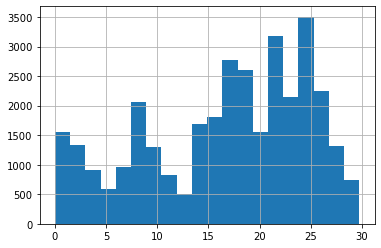

In [176]:
transcript[transcript.event == 'offer completed'].time_days.hist(bins=20);

Time_days range from zero to 30 indicating that for each customer, we have only the first 30 days of data coverage beginning when the customer first signed up with the app.  

First sign_up date:  2013-07-29 00:00:00
Last sign_up date:  2018-07-26 00:00:00


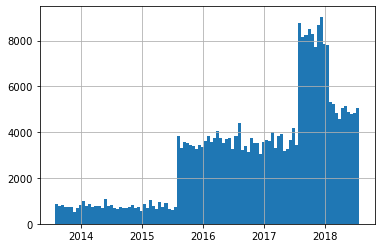

In [177]:
print('First sign_up date: ', transcript.signed_up.min())
print('Last sign_up date: ', transcript.signed_up.max())
transcript.signed_up.hist(bins=100);

Examining a histogram of number of events per year shows an increasing trend for later years, with a dip back down in 2018. <br>Since the histogram has a step shape, this is likely due to the way that the data has been sampled

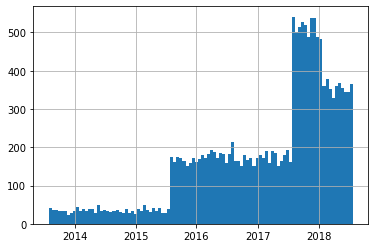

In [178]:
transcript[['person', 'signed_up']].drop_duplicates().signed_up.hist(bins=100);

Comparing this to a histogram of number of customers per year shows a similar pattern. <br> The varying number of transactions per year is therefore predominently driven by number of customers sampled not by an increasing number of events per customer.

In [179]:
def plot_person(person):
    '''
    Plots visualisation of customer's event history.

    Parameters
    -----------
    person: if int then customer index as per the order in which 
    customer appears in transcript data. If string then person 
    referenced by their unique 'person' id                
    '''
    x=[]
    y=[]    
    markers = ['o', 'v', '^', 'o']
    
    for i, event in enumerate(['transaction', 'offer received', 'offer viewed', 
                               'offer completed']):
        # step plot of cumulative transactions
        if event=='transaction':
            x.append(person_data(person).time_days)
            y.append(person_data(person).cum_amount)               
            plt.step(x[i], y[i], alpha=.3, label=event, color='black', where='post')
            
        # scatter plot of events
        else:
            try:
                x.append(person_data(person)[person_data(person).event==event].time_days)
                y.append(person_data(person)[person_data(person).event==event].cum_amount)
                plt.scatter(x[i], y[i], alpha=0.7, label=event, marker=markers[i], s=80)
            except:
                pass
            
        # required spending per time for each offer received     
        if event=='offer received':
                      
            received = person_data(person)[person_data(person).event=='offer received']\
                                          [['time_days', 'difficulty', 'cum_amount', 'duration']]\
                                          .reset_index()
            
            for i in received.index:
                x_diff = [received.iloc[i].time_days, 
                          received.iloc[i].time_days+received.iloc[i].duration]
                y_diff = [received.iloc[i].cum_amount, 
                          received.iloc[i].cum_amount+received.iloc[i].difficulty]
                plt.plot(x_diff, y_diff, color='blue', alpha=.15, linewidth='2')
    
    plt.xlabel('time(days)')
    plt.ylabel('cumulative spend')
    plt.title(f'Customer event history - {person_data(person).person.max()}')
    plt.legend()
    plt.show()

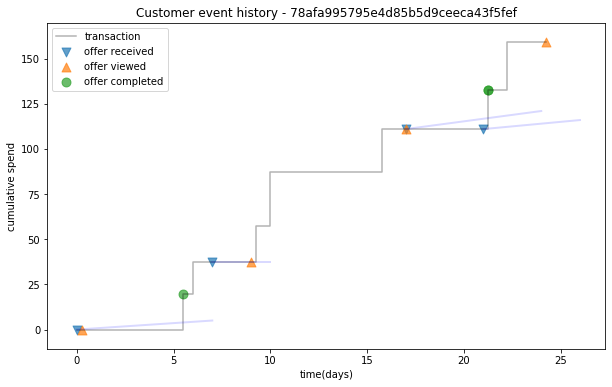

In [180]:
plt.figure(figsize=(10,6))
plot_person(0)

We can visualise any customer's 'journey' over the 30 day period by plotting cumulative transaction spend and offer events <br>
versus time.
* Offers received are indicated by blue lines representing the duration of offer validity (x-axis) vs difficulty (y-axis).
* If the customers cumulative transaction spend (visually a step function) is above the tail end of an offer received line, this indicates <br>
that the customer has spent enough during the validity period to complete the offer.

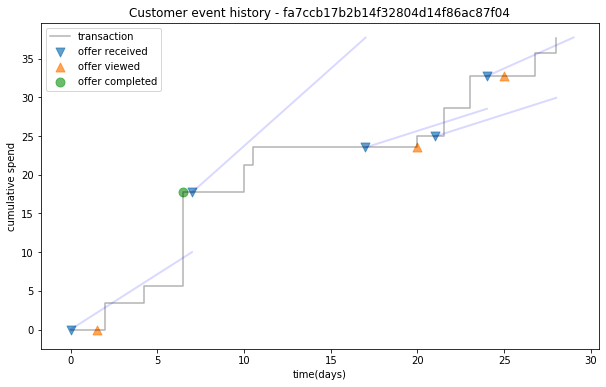

In [181]:
# Plotting customer event history of person 57 (person='fa7ccb17b2b14f32804d14f86ac87f04')
plt.figure(figsize=(10,6))
plot_person(57)

For the person in the above example we can see that the first offer ('**e**' with difficulty 10 and duration 7) was received at time <br>
zero. By day 6.5, the offer was completed with total spend during the validity period of 17.72.

In contrast, the next four offers were not completed, visually this is seen as the transaction spending step line falling below <br>
the offer received lines.

Since the customer is not aware of an offer until they view it, a key question will be to compare how much is spent <br>
during the period when the customer has knowledge of an offer vs when they do not.

Visually a customer who is responsive should have a steeper cumulative transaction spending line after an offer is viewed compared to before. <br>A completely unresponsive customer would have zero difference in rate of spending when an offer is viewed.

### 1.2 Discussing spending effects on customers
We can think of the different spending effects acting on the customer as follows:

* **Base customer demographic effect** 
 * The mean tendencies of a customer based on demographic effects.
     * Age
     * Income
     * Gender


* **Individual personal customer effect**
 * Individual's spending tendancies not already captured by base demographic effects, these can be thought of as additive to the base effect.<br> 
 At any point in time we can look back at the customer's previous spending and offer response history. It is reasonable to hypothesise that <br>
 features based on history may be able to encapsulate behavioural tendancies and be predicitve of future behaviour.
   * Historical spending
   * Historical completion of offers / failures to complete
   * Degree of reactivity to an offer or level of indifference
 
 
* **Situational effects** (time dependent)
 * Offer effect - Has the customer viewed an offer and is therefore currently under its influence for the specified duration? Responsiveness to the current offer will depend on individual tendency. 
 * Previous spending effect - E.g. how much did the customer spend yesterday using the Starbucks app, how about last week? Does this affect how much they will likely spend today?


* **Baseline spending**
 * If currently not under the influence of an offer, how much does the customer spend?
 
When it comes to feature engineering we will aim to encapsulate all of these effects within our models.

In [182]:
transcript

,offer_id,person,event,time,age,income,signed_up,F,M,O,amount,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,cum_amount,joined,offer received,offer viewed,offer completed,transaction,time_days
0,78afa995795e4d85b5d9ceeca43f5fefg1,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,75.0,100000.0,2017-05-09,1,0,0,0.00,g,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.00,-443,1,0,0,0,0.00
1,78afa995795e4d85b5d9ceeca43f5fefg1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,75.0,100000.0,2017-05-09,1,0,0,0.00,g,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.00,-443,0,1,0,0,0.25
2,78afa995795e4d85b5d9ceeca43f5fef01,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,75.0,100000.0,2017-05-09,1,0,0,19.89,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.89,-443,0,0,0,1,5.50
3,78afa995795e4d85b5d9ceeca43f5fefg1,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,75.0,100000.0,2017-05-09,1,0,0,0.00,g,5.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,19.89,-443,0,0,1,0,5.50
4,78afa995795e4d85b5d9ceeca43f5fef02,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,75.0,100000.0,2017-05-09,1,0,0,17.78,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.67,-443,0,0,0,1,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93c1,912b9f623b9e4b4eb99b6dc919f09a93,offer received,576,NaN,NaN,2017-09-26,0,0,0,0.00,c,0.0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.00,-303,1,0,0,0,24.00
306530,912b9f623b9e4b4eb99b6dc919f09a93c1,912b9f623b9e4b4eb99b6dc919f09a93,offer viewed,594,NaN,NaN,2017-09-26,0,0,0,0.00,c,0.0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.00,-303,0,1,0,0,24.75
306531,3045af4e98794a04a5542d3eac939b1fc1,3045af4e98794a04a5542d3eac939b1f,offer received,576,58.0,78000.0,2016-10-20,1,0,0,0.00,c,0.0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.00,-644,1,0,0,0,24.00
306532,3045af4e98794a04a5542d3eac939b1fc1,3045af4e98794a04a5542d3eac939b1f,offer viewed,576,58.0,78000.0,2016-10-20,1,0,0,0.00,c,0.0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.00,-644,0,1,0,0,24.00


### 1.3. Feature Examination

#### Event
We can see that customer purchase transactions are the most common event followed by offer received, and as expected offers viewed and completed are less frequent. 

In [183]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

There are 6 unique specific times that offers can be received - days 0, 7, 14 , 17, 21 and 24.

In [184]:
offer_received_counts = transcript[transcript.event=='offer received']\
                        .time_days.value_counts().sort_index()
print(offer_received_counts)
print(f'mean: {offer_received_counts.mean()}  std: {offer_received_counts.std()}')

0.0     12650
7.0     12669
14.0    12711
17.0    12778
21.0    12704
24.0    12765
Name: time_days, dtype: int64
mean: 12712.833333333334  std: 50.83076496243851


We can see that there are approximately 12713 offers per time period across all customers. With an STD of only 50, these are approximately the same number of offers given per time period.

If we group by customer and plot offers received per customer:

In [185]:
customer_offer_counts = transcript[transcript.event=='offer received'].groupby('person')\
                        .event.count()
print(f'Average offers received: {customer_offer_counts.mean()}')
print(customer_offer_counts.value_counts().sort_index())

Average offers received: 4.488466517594445
1      73
2     610
3    2325
4    4988
5    5931
6    3067
Name: event, dtype: int64


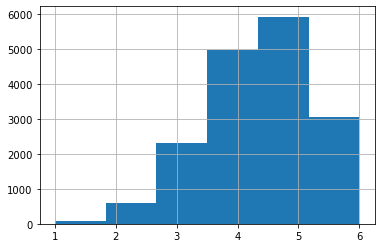

In [186]:
customer_offer_counts.hist(bins=6);

Only 73 customers received only one offer, the average was 4.49 offers per customer and the most was 6 offers given to 3067 customers.

Breaking down the offers into the specific 10 types (a to j), we can see that on average each of the offers is given 7627.7 times with SD of 35.

In [187]:
total_offers_per_type = transcript[transcript.event=='offer received'].id.value_counts()
print(total_offers_per_type[:-1])
print(f'mean: {total_offers_per_type[:-1].mean()}, SD: {total_offers_per_type[:-1].std()}')

g    7677
a    7668
b    7658
f    7646
e    7632
j    7618
i    7617
d    7597
c    7593
h    7571
Name: id, dtype: int64
mean: 7627.7, SD: 34.794795268513624


Furthermore breaking down per period we see that each offer is given on average 1271 times with SD of 28. This indicates that with respect to number of offers, the dataset is balanced.

In [188]:
offer_ids_per_time = transcript[transcript.event=='offer received']\
                    .groupby('time_days').id.value_counts()
print(f'mean: {offer_ids_per_time.mean()}, SD: {offer_ids_per_time.std()}')
print(offer_ids_per_time )

mean: 1271.2833333333333, SD: 28.38840278052604
time_days  id
0.0        d     1318
           a     1297
           b     1292
           i     1273
           j     1266
           h     1263
           e     1257
           g     1245
           f     1221
           c     1218
7.0        b     1319
           g     1296
           e     1270
           j     1270
           i     1266
           h     1263
           d     1250
           f     1250
           a     1245
           c     1240
14.0       a     1322
           f     1301
           c     1280
           i     1279
           g     1275
           e     1263
           j     1256
           h     1247
           b     1245
           d     1243
17.0       e     1335
           c     1308
           j     1293
           b     1278
           i     1275
           f     1274
           g     1274
           a     1269
           h     1250
           d     1222
21.0       c     1310
           h     1305
           e  

In [189]:
for i in transcript.event.unique():
    print(f'{i}: {transcript[transcript.event==i].time_days.nunique()}')

offer received: 6
offer viewed: 120
transaction: 120
offer completed: 120


Offer viewed, transaction and offer completed have 120 possibilities. Looking at the unique values we can see that the timing of these is split into 0.25 of a day or 6 hours. This is the smallest unit of time measurement available hence 30 days * 4 = 120 unique possible values. We can assume that when an events occurs it is recorded as falling into a 6 hour time window.

In [190]:
print(np.sort(transcript[transcript.event=='offer viewed'].time_days.unique()))

[ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75
 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75 14.   14.25 14.5  14.75
 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75
 18.   18.25 18.5  18.75 19.   19.25 19.5  19.75 20.   20.25 20.5  20.75
 21.   21.25 21.5  21.75 22.   22.25 22.5  22.75 23.   23.25 23.5  23.75
 24.   24.25 24.5  24.75 25.   25.25 25.5  25.75 26.   26.25 26.5  26.75
 27.   27.25 27.5  27.75 28.   28.25 28.5  28.75 29.   29.25 29.5  29.75]


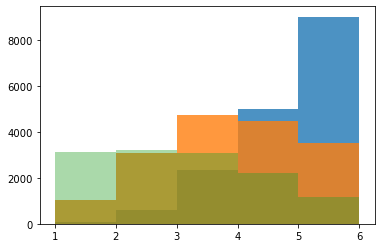

In [191]:
plt.hist(transcript[transcript.event=='offer received']\
         .groupby('person').event.count(), bins=5, alpha=0.8)
plt.hist(transcript[transcript.event=='offer viewed']\
         .groupby('person').event.count(), bins=5, alpha=0.8)
plt.hist(transcript[transcript.event=='offer completed']\
         .groupby('person').event.count(), bins=5, alpha=0.4);

Plotting histograms of total events per customer

* blue:   offers received
* orange: offers viewed
* green:  offers completed 

We can see an on average decreasing funnel: <br>
Received > Viewed > Completed

This is not always strictly the case since there is also the situation of completion without having been viewed. 

#### Scatter plots - Age, Income, Joined

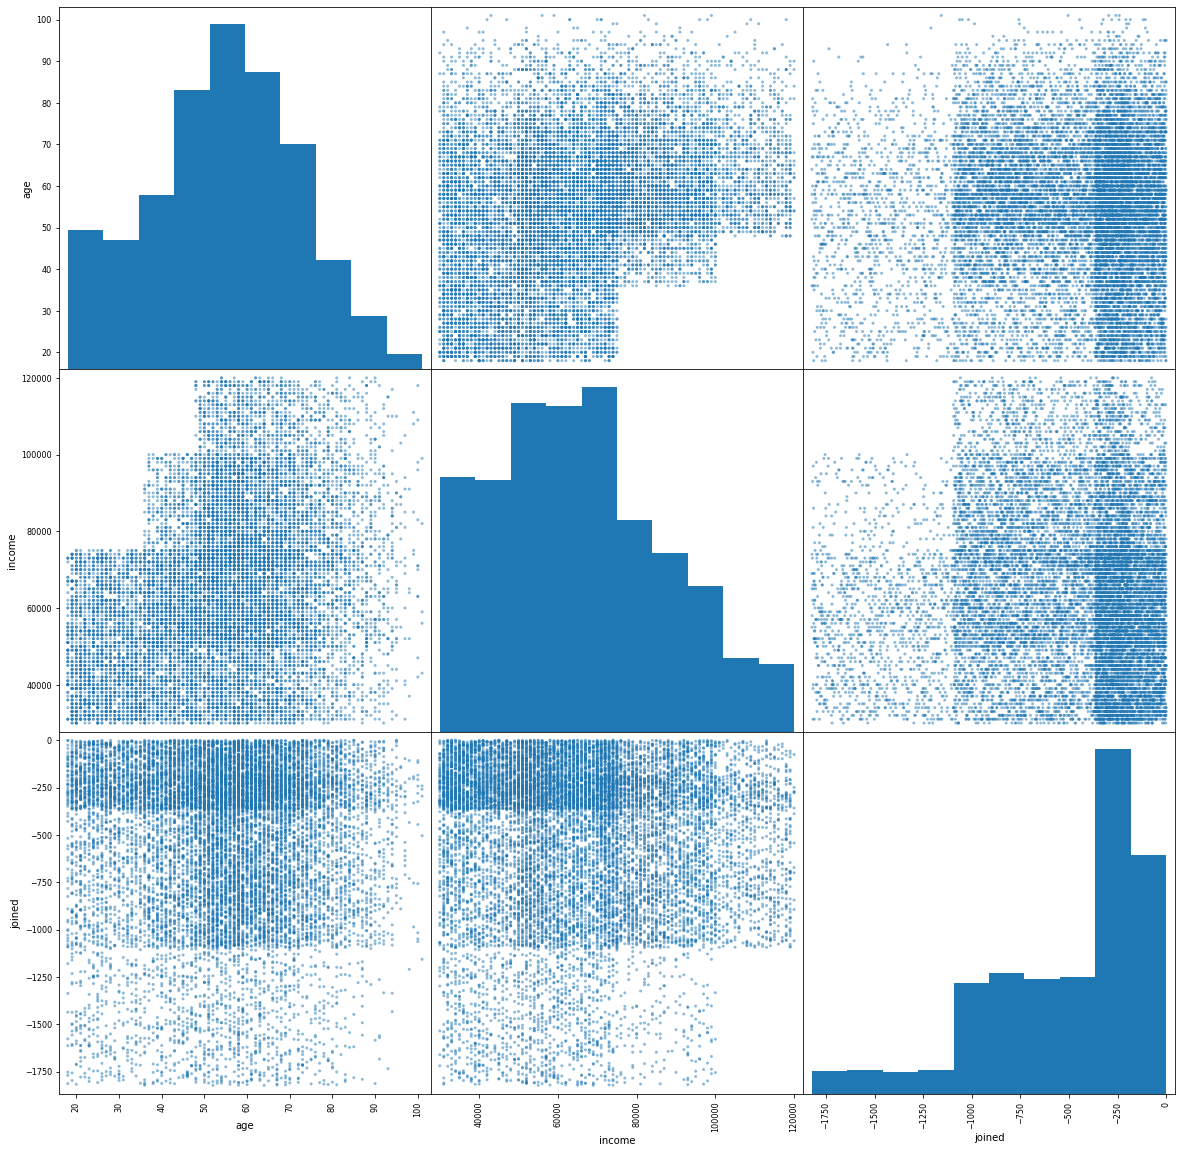

In [192]:
pd.plotting.scatter_matrix(transcript.groupby(['person'])\
                           [['age', 'income', 'joined']].mean(), figsize=(20,20));

Scatter plots of age, income and joined reveal the following patterns.

Age 
* Skewed to the right with minimum age of 18 and max 101. 
* Higher than expected number of customers at age 18 suggest some may be under aged and have selected 18 as the minimum possible.

Age vs Income
* The scatter plot appears as a blocky grid and not following a skewed normally distributed pattern as we would expect.
* We can see that there are no ages below or equal to 35 with an income over 75k.
* Similarly no ages less than or equal to 47 had an income over 100k.
* From this plot it appears that for whatever reason these potential customers have not been included in the sample process. Could it be that these might represent outliers and have been removed?

Age vs joined
* Appears normally distributed with abritrary increasing volume of customers sampled at later dates.

Income 
* Ranges from 30k to 120k, right skewed.

Income vs joined
* Again we see a blocky scatter plot suggesting dependency on the method of sampling.
* The oldest experiements (joined < 1100) do no include income above 100k. Perhaps this was the max option for the app at this time?

Joined
* Trend of increasing number of customers as time progresses.

#### Gender

In [193]:
for i in ['M', 'F', 'O']:
    print(f'{i}: {transcript.groupby("person")[i].max().sum()}')

M: 8484
F: 6129
O: 212


Comparing the above scatter plots but for male and female separately we do see a difference particularlly in the distribution of income. 
It appears there has been a greater sampling of low income males particularly the most recent customers to join.

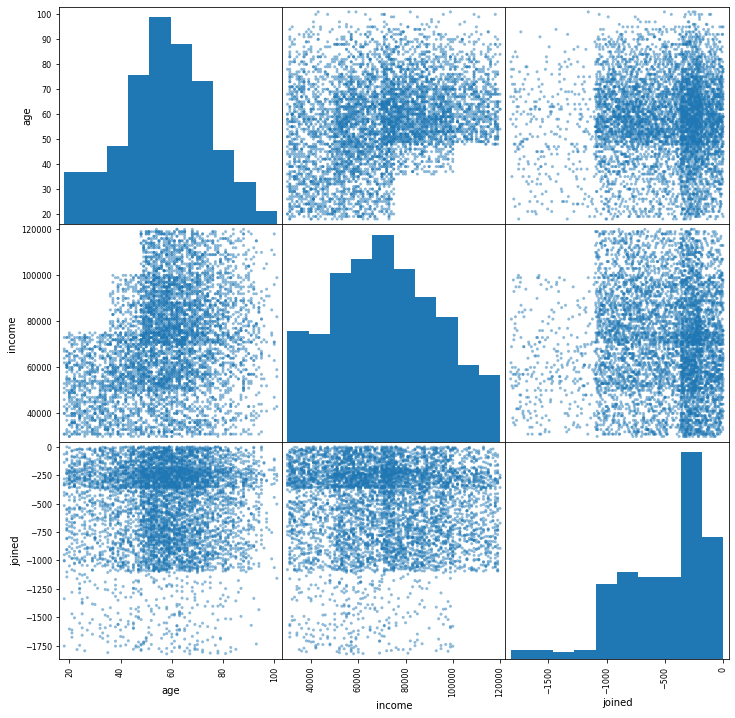

In [194]:
# Female
pd.plotting.scatter_matrix(transcript[transcript.F==1].groupby(['person'])\
                           [['age', 'income', 'joined']].mean(), figsize=(12,12));

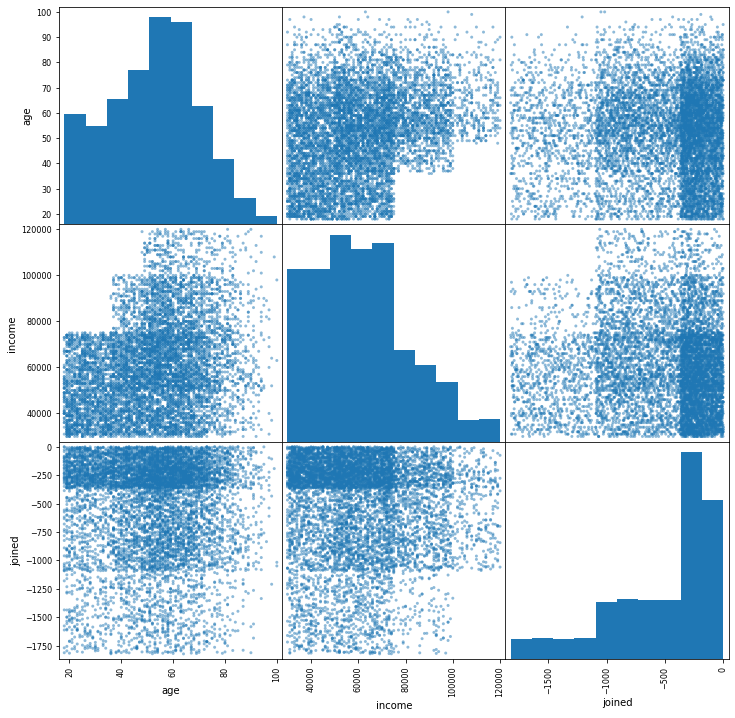

In [195]:
# Male
pd.plotting.scatter_matrix(transcript[transcript.M==1].groupby(['person'])\
                           [['age', 'income', 'joined']].mean(), figsize=(12,12));

## 2. Feature Engineering

### 2.1 Encoding date of each event

Creating new column with date of event - assuming that 0 is equal to signed up date.
* Adding day, weekday, month and year features.

In [196]:
def date_features(transcript, save=None):
    ''' 
    Create various date/time features
    
    Parameters
    -----------
    transcript: DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder 
            '../../data/interim' 
    Returns
    -------
    DataFrame
    '''
          
    transcript['time_days'] = transcript.time / 24
    transcript['date'] = transcript.signed_up + pd.to_timedelta(transcript.time_days, unit='D')
    transcript['day'] = transcript.date.dt.day
    transcript['weekday'] = transcript.date.dt.dayofweek
    transcript['month'] = transcript.date.dt.month
    transcript['year'] = transcript.date.dt.year
    
    save_file(transcript, save) 
    
    return transcript

### 2.2 Encoding past transaction features
>Hypothesising that the previous spending habits of a customer will help predict their future spending habits. Currently transactions are listed as separate rows and will need to be mapped to one row only. We will take each offer received as an observation and map historical spending before the offer was received to buckets of total spending going back 1, 3, 7, 14, 21 and 30 days in the past. This should capture the effect of trends. The same will be done for the number of transactions since a customer's frequency of purchase may have a different effect to total spending value e.g few large purchases vs many small purchases.

In [197]:
def df_numpydict(df, df_columns):
    '''
    Converts index and specified columns of a dataframe into a 
    dictionary of numpy arrays. Speeds up loop operations. 
    
    Parameters
    -----------
    df:  DataFrame
    df_columns: list of required columns names
    
    Returns
    -------
    dictionary of numpy arrays
    '''
    dict_np = {column: df[column].to_numpy() for column in df_columns}
    dict_np['index'] = df.index.to_numpy()
    return dict_np   

In [198]:
def try_join(new_data, transcript):
    '''
    Joins new_data DataFrame to transcript DataFrame
    if columns already exist in transcript, drops them before joining.
        
    Parameters
    -----------
    new_data: DataFrame
    transcript: DataFrame
            
    Returns
    -------
    Dataframe    
    
    '''
    try:
        transcript.drop(new_data.columns, axis=1, inplace=True)
    except:
        pass
    
    transcript = transcript.join(new_data)
    return transcript

In [199]:
def create_transaction_ranges(transcript, save=None):
    '''
    Creates time bucket fields for total transaction value and number 
    of transactions going back in time from offer received.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder 
            '../../data/interim'
    Returns
    -------
    DataFrame
    '''
    
    transaction_days_range = [30,21,14,7,3,1]  
    hist = {}
    
    # initialsiing dictionary of numpy arrays for each transaction
    # and count
    
    for m in transaction_days_range:
        transaction_range = f't_{m}'       
        transaction_range_count = f'{transaction_range}c'
        hist[transaction_range] = np.zeros(transcript.shape[0])
        hist[transaction_range_count] = np.zeros(transcript.shape[0])
    
    # convert required dataframe columns to dictionary of numpy arrays
    t = df_numpydict(transcript, ['event', 'person', 'time_days', 'amount'])
   
    bar = progressbar.ProgressBar()
    
    # loop through each row index
    for i in bar(t['index']):
        if t['event'][i] =='offer received':
            
            # loop backwards through events of customer
            for j in t['index'][0:i][::-1]:
                if t['person'][j] != t['person'][i]:
                    break                
                
                # if transaction, how many days before offer received?
                if t['event'][j] == 'transaction':                                       
                    day_diff = t['time_days'][i] - t['time_days'][j]
                    
                    # loop through transaction day ranges and  
                    # increment transaction value and
                    # increment transaction count
                    for m in transaction_days_range:
                        transaction_range = 't_' + str(m)
                        transaction_range_count = transaction_range + 'c'
                        
                        if day_diff <= m:                            
                            hist[transaction_range][i] += t['amount'][j]
                            hist[transaction_range_count][i] += 1
                           
                        else:
                            break
                            
    new_data = pd.DataFrame(hist)[['t_1', 't_3', 't_7', 't_14', 't_21', 't_30',
                                     't_1c', 't_3c', 't_7c', 't_14c', 't_21c', 't_30c']]
    
    transcript = try_join(new_data, transcript)

    save_file(transcript, save)  

    return transcript

### 2.3 Create last transaction and amount features
> Hypthothesising that the last transaction amount before an offer is viewed, and date of last transaction will affect affect liklihood of offer completion.

In [200]:
def last_transaction(transcript, save=None):
    '''
    Creates last transaction in days and last amount spent features.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder 
            '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''
    
    t = df_numpydict(transcript, ['event', 'person', 'time_days', 'amount'])
    
    tran_index = transcript.index.to_numpy()
    tran_event = transcript.event.to_numpy()
    person = transcript.person.to_numpy()
    time = transcript.time_days.to_numpy()
    amount = transcript.amount.to_numpy()
    
    last_transaction_days = np.full(transcript.shape[0], np.nan)
    last_amount = np.full(transcript.shape[0], np.nan)

    bar = progressbar.ProgressBar()
    
    # loop through each row
    for i in bar(t['index']):
        if t['event'][i] =='offer received':
            
            # loop backwards through events of customer
            for j in t['index'][0:i][::-1]:
  
                if t['person'][j] != t['person'][i]:
                    break

                if tran_event[j] == 'transaction':
                    last_transaction_days[i] = t['time_days'][i] - t['time_days'][j]
                    last_amount[i] = amount[j]
                    break
    
    transcript['last_transaction_days'] = last_transaction_days
    transcript['last_amount'] = last_amount
            
    save_file(transcript, save)        

    return transcript

### 2.4 Create offer received, viewed and related spending features

We do not want to target customers that would spend the required amount or a large proportion of it without viewing an offer as this will reduce profit.<br>
Our aim is to target customers that are responsive and will increase spending as soon as an offer is viewed. 

The following features are created to assess different spending habits when an offer is received and viewed: <br>
* **received_spend** -  How much has a customer spent towards an offer before viewing it? <br>
* **viewed_spend** - How much spending was made within the validity period after viewing an offer? <br>
* **viewed_days_left** -  How many days left to complete an offer after viewing it? <br>
* **remaining_to_complete** - How much did customer spend after viewing the offer? <br>
* **viewed_in_valid** - Did the customer actually view the offer during the valid period? <br>

In [201]:
def viewed_received_spend(transcript, save=None):
    '''
    Creates received_spend, viewed_spend, viewed_days_left, 
    remaining_to_complete, viewed_in_valid feautures
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder 
            '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''   
    t = df_numpydict(transcript, ['event', 'person', 'difficulty', 'time_days', 
                                  'duration', 'amount', 'id'])
    
    viewed_in_valid = np.zeros(transcript.shape[0])
    received_spend = np.zeros(transcript.shape[0])
    viewed_days_left = np.full(transcript.shape[0], 0.0)
    viewed_spend = np.zeros(transcript.shape[0])
    remaining_to_complete = np.full(transcript.shape[0], np.nan)
    viewed_already = np.zeros(transcript.shape[0])
        
    bar = progressbar.ProgressBar()
    for i in bar(t['index']):
        if t['event'][i] == 'offer received':

            for j in t['index'][i+1:]:                        
                
                # check if still same person
                if t['person'][j] != t['person'][i]:
                    break
                
                # check if period is within duration
                if t['time_days'][j] - t['time_days'][i] > t['duration'][i]:
                    break
                
                # if offer viewed, update how many days left in the 
                # offer, update how much remaining spending needed
                if t['event'][j] == 'offer viewed':                
                    if (viewed_already[j] != 1) and (t['id'][i] == t['id'][j]):
                        viewed_in_valid[i] = 1

                        if received_spend[i] <= t['difficulty'][i]:                        
                            viewed_days_left[i] = t['duration'][i]\
                                                  - (t['time_days'][j] - t['time_days'][i])
                            
                            remaining_to_complete[i] = t['difficulty'][i] - received_spend[i]
                            
                            if remaining_to_complete[i] < 0:
                                remaining_to_complete[i] =0
                            
                            viewed_already[j] = 1

                        if received_spend[i] > t['difficulty'][i]:  
                            viewed_days_left[i] = 0
                            remaining_to_complete[i] = 0
                            viewed_already[j] = 1
                     
                if t['event'][j] == 'transaction':
                    
                    # update spending when received but not viewed      
                    if viewed_days_left[i] <=0:
                        received_spend[i] += t['amount'][j]                        
                                           
                    # update spending when viewed
                    if viewed_days_left[i] > 0:
                        viewed_spend[i] += t['amount'][j]
    
    transcript['received_spend'] = received_spend
    transcript['viewed_spend'] = viewed_spend
    transcript['viewed_days_left'] = viewed_days_left
    transcript['remaining_to_complete'] = remaining_to_complete
    transcript['viewed_in_valid'] = viewed_in_valid
    
    save_file(transcript, save)       

    return transcript

### 2.5 Overlap offer effect
Sometimes the customer can be affected by overlapping offers at the same time. For example the following example shows the 4th offer duration overlapping with both the 3rd and 5th.
When two offers are both in effect this may further increase the liklihood of customer spending.

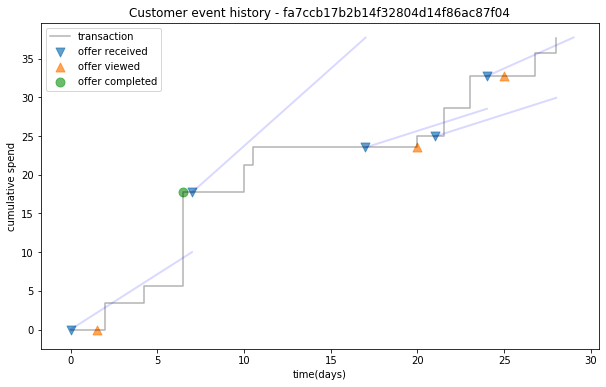

In [202]:
plt.figure(figsize=(10,6))
plot_person(57)

The following function will create overlap features, one for each of features a to j.

In [203]:
def overlap_offer_effect(transcript, save=None):
    '''
    Creates overlap offer feature columns [a,b,c,d,e,f,g,h,i,j] with 
    integer value equal to the duration for which the previous offer 
    is still valid.
        
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder 
            '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''              
    # convert required dataframe columns to dictionary of numpy arrays
    t = df_numpydict(transcript, ['event', 'person', 'time_days', 'duration', 'id'])
    
    overlap_offer = np.empty(transcript.shape[0], dtype=str)
    overlap_offer_days = np.full(transcript.shape[0], np.nan)
            
    bar = progressbar.ProgressBar()
    for i in bar(t['index']):
        if t['event'][i] == 'offer received': 

            # loop backwards through events of customer
            for j in t['index'][0:i][::-1]:
                if t['person'][j] != t['person'][i]:
                    break
                if t['event'][j] == 'offer completed':
                    break

                if t['event'][j] == 'offer received':
                    days_left = t['time_days'][j] - t['time_days'][i] + t['duration'][j]
                    
                    if days_left <= 0:
                        continue

                    overlap_offer_days[i] = days_left
                    overlap_offer[i] = t['id'][j]
                               
    offer_overlap_features = pd.get_dummies(overlap_offer, drop_first=True)\
                                            .mul(overlap_offer_days, axis=0).replace(0, np.nan)
    transcript = try_join(offer_overlap_features, transcript)
    
    save_file(transcript, save)  
   
    return transcript

### 2.6 Mapping Events

The following functions maps offer completed or offer viewed to the offer received row of the dataset. As earlier discussed, information about each offer will need to be condensed into one row before we can utilise the data in a machine learning algorithm. 

In [204]:
def match_verification(transcript, event=None):
    '''
    Helper function that validates whether total number of events(offer 
    completed or offer viewed) from raw data matches newly created 
    'complete' or 'viewed' feature.
    
    Parameters
    -----------
    transcript:  DataFrame
    event: string ('offer received' or 'offer completed')
    '''     
    
    if event == 'offer completed':
        eventid = 'completed'
    elif event == 'offer viewed':
        eventid = 'viewed'
    
    raw = transcript[transcript.event == event].groupby('person').id.count()    
    calculated = transcript.groupby('person')[eventid].sum()

    # joining by id to match persons
    comparison_df = pd.DataFrame(calculated).join(raw)
    comparison_df.id.replace(np.nan,0, inplace=True)
    comparison_df[eventid].replace(np.nan,0, inplace=True)

    # Checking that there are no differences between each user
    if (comparison_df.id - comparison_df[eventid])\
        .value_counts()[0.0] == transcript.person.nunique():
        print(event, ' mapped to offer rows correctly')
    else:
        print('some ' + event + 'mapped incorrectly, please compare:')
        display(comparison_df[comparison_df[eventid] - comparison_df.id != 0])

In [205]:
def mapping_event(transcript, event=None, save=None):
    '''
    Maps the events 'offer completed' or 'offer viewed' to the corresponding 'offer received' 
    row of the dataset
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''     
    
    t = df_numpydict(transcript, ['event', 'person', 'time_days', 'duration', 'id'])
        
    if event == 'offer completed':
        eventid = 'completed'
        event_check = 'already_completed'
    elif event == 'offer viewed':
        eventid = 'viewed'
        event_check = 'already_viewed'
    
    t[event_check] = np.zeros(transcript.shape[0])
    t[eventid] = np.zeros(transcript.shape[0])
    t[event + '_date'] = np.full(transcript.shape[0], np.nan)
    
    bar = progressbar.ProgressBar()

    for i in bar(t['index']):
        if t['event'][i] == 'offer received':

            for j in t['index'][i+1:]:
                
                if t[event_check][j] == 1:
                    continue
                
                # check if still same person
                if t['person'][j] != t['person'][i]:
                    break
                
                # check if period is within duration
                if event == 'offer completed':        
                    if t['time_days'][j] - t['time_days'][i] > t['duration'][i]:
                        break
                
                # if offer viewed, update how many days left in the offer, update how much 
                # remaining spending needed
                if t['event'][j] == event:                                       
                    
                    if t['id'][j] == t['id'][i]:
                        t[event_check][j] = 1
                        t[eventid][i] = 1
                        t[event + '_date'][i] = t['time_days'][j] 
                        break
    
    transcript[event_check] = t[event_check]
    transcript[eventid] = t[eventid]
    transcript[event + '_date'] = t[event + '_date']
       
    match_verification(transcript, event=event)
    transcript.drop([event_check], axis=1, inplace=True)
    
    save_file(transcript, save)         

    return transcript

### 2.7 Spending habits under and not under offer influence

The following features are created to determine spending when under the influence of an offer and base spending when not under the unfluence of any offers. Since we are trying to capture the effect of offers on spending, this is only valid when the customer is aware that an offer is in effect. We therefore distinguish between two categories
> * **Under the influence** of an offer means the offer is active and the customer is aware of it
> * **Not under the influence** means either no offer is active or an offer is active but the customer is not aware of it.


* **amount_while_offer** - Amount spent while under influence of current offer
* **amount_not_offer** - Amount spent while not under the influence of current offer.
* **percentage_offer_active** - The percentage of time so far under the influence
* **offer_active_count** - The numer of days so far that customer has been under the influence.
* **no_offer_count** - The number of days so far that customer has not been under the influence.
* **offer_cum_amount** - Cumulative amount spent while under influence.
* **no_offer_cum_amount** - Cumulative amount spent not under influence. 
* **amount_per_day_offer** - Average amount per day spent under influence
* **amount_per_day_not_offer** - Average amount per day spend not under influence. 

In [206]:
def start_end_range(transcript, save=None):
    '''
    Calculates date ranges when offers are under influence for each 
    offer received.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder 
            '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''
    
    bar = progressbar.ProgressBar()
    
    t = df_numpydict(transcript, ['offer viewed_date', 'time_days', 'viewed_days_left', 
                                  'offer completed_date', 'difficulty']) 
    
    t['start_range'] = np.full(transcript.shape[0], np.nan)
    t['end_range'] = np.full(transcript.shape[0], np.nan)
    
    for i in bar(t['index']):
        
        # Since informational offers cannot be completed, these are 
        # ignored
        if t['difficulty'][i] == 0:
            continue
        
        # if offer not viewed, start and end dates are NaN
        if not t['offer viewed_date'][i]:
            t['start_range'][i] = np.nan
            t['end_range'][i] = np.nan
            continue
        
        # if viewed on last day, only valid on that day
        if t['viewed_days_left'][i] == 0:
            t['end_range'][i] = t['time_days'][i]
            t['start_range'][i] = t['time_days'][i]
            continue
        
        # if completed, influence range is from viewed to completed date
        if t['offer completed_date'][i] >= 0:
            t['start_range'][i] = t['offer viewed_date'][i]
            t['end_range'][i] = t['offer completed_date'][i]
            continue
        else:
            # if not completed, influence range is from viewed date to 
            # end of offer duration
            t['end_range'][i] = t['offer viewed_date'][i] + t['viewed_days_left'][i]
            t['start_range'][i] = t['offer viewed_date'][i]
            continue
            
    transcript['start_range'] = t['start_range']
    transcript['end_range'] = t['end_range']
            
    return transcript

In [207]:
def ranges(transcript, save=None):
    '''
    Creates features:
    
    amount_while_offer 
    amount_not_offer
    percentage_offer_active 
    offer_active_count    
    no_offer_count       
    offer_cum_amount 
    no_offer_cum_amount 
    amount_per_day_offer 
    amount_per_day_not_offer 
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''

    bar = progressbar.ProgressBar()
    
    t = df_numpydict(transcript, ['offer viewed_date', 'time_days', 'viewed_days_left', 
                                  'offer completed_date', 'difficulty', 'person', 'start_range', 
                                  'end_range', 'amount']) 
        
    # create base np array of 120 discreet points from 0 to 30 to 
    # represent each possible time increment
    base = np.arange(0, 30.25, .25)

    # create empty list for each offer in transcript
    ranges = [[] for i in range(transcript.shape[0])]
    
    # instansiate a list that will hold an array for each offer of the 
    # 120 discreet time increments possible
    discreet_ranges = []   
    
    # for each offer loop back in time and append array of start and 
    # end ranges to list within list of ranges
    for i in bar(t['index']):
        for j in t['index'][0:i][::-1]:
            
            # if different person break
            if t['person'][j] != t['person'][i]:
                break 
            
            if t['start_range'][j] >= 0:
                ranges[i].append(np.array([t['start_range'][j], t['end_range'][j]]))
       
    for i in ranges:
        # if no offer ranges, add empty list to discreet ranges
        if i == []:
            discreet_ranges.append([])
            continue
        
        # if there is only one range of offer influence
        if len(i) == 1:
            
            # create array of booleans where base array of time 
            # increments satisfies influence range condition
            offer_range = np.where((base >= i[0][0]) & (base <= i[0][1]))[0]/4
            discreet_ranges.append(offer_range)
            continue
        
        # if more than one range of offer influences
        if len(i) >1:
            offer_range = np.empty(0)
            
            # update array of booleans where base array of time
            # increments satisfies all range conditions
            for j in i:
                offer_range = np.append(offer_range, np.where((base >= j[0]) & (base <= j[1]))[0]/4)
        
        # in the case of overlapping influences, only appends unique
        # time increments
        discreet_ranges.append(np.unique(offer_range))
 
    
    offers_active_list = []
    for i in discreet_ranges:
        offer_active = np.full(121, np.nan)
        
        # if offer has no historical influence, append full array of
        # NaNs
        if len(i) == 0:
            offers_active_list.append(offer_active)
            continue         
        
        # if offer has historical influence, replace boolean value from 
        # discreet ranges indicating positive influence with the actual 
        # time value in offers active 
        if len(i) > 0:
            for j in i:
                offer_active[int(j*4)] = j
            offers_active_list.append(offer_active)
     
    t['amount_while_offer'] = np.zeros(transcript.shape[0])
    t['percentage_offer_active'] = np.zeros(transcript.shape[0])
    t['amount_not_offer'] = np.zeros(transcript.shape[0])
    t['offer_active_count'] = np.zeros(transcript.shape[0])
    t['no_offer_count'] = np.zeros(transcript.shape[0])
    
    for i in t['index']:
        time = t['time_days'][i]
        
        if time == 0:
            t['amount_while_offer'][i] = t['amount'][i]
            
            # percentage of discreet time increments that offer is active
            t['percentage_offer_active'][i] = (offers_active_list[i][0:int(time*4)] >= 0).sum()/1
            continue            
        
        
        if time in offers_active_list[i]:
            t['amount_while_offer'][i] = t['amount'][i]
        else:
            t['amount_not_offer'][i] = t['amount'][i]
        
        # calculate percentage of time offers active, as well as absolute length of time offers
        # active
        t['percentage_offer_active'][i] = (offers_active_list[i][0:int(time*4 +1)] >= 0)\
                                          .sum()/(time*4 +1)
        t['offer_active_count'][i] = (offers_active_list[i][0:int(time*4 +1)] >= 0).sum()
        t['no_offer_count'][i] = (~(offers_active_list[i][0:int(time*4 +1)] >= 0)).sum()
    
         
    # add new features to transcript    
    transcript['offers_active'] = offers_active_list
    transcript['amount_while_offer'] = t['amount_while_offer']
    transcript['percentage_offer_active'] = t['percentage_offer_active']
    transcript['amount_not_offer'] = t['amount_not_offer']
    transcript['offer_active_count'] = t['offer_active_count'] / 4
    transcript['no_offer_count'] = t['no_offer_count'] / 4
    
    # calculate cumulative sum amount per person
    transcript['offer_cum_amount'] = transcript.groupby('person').amount_while_offer.cumsum()
    transcript['no_offer_cum_amount'] = transcript.groupby('person').amount_not_offer.cumsum()
    
    # convert cumulative amount to per day average
    transcript['amount_per_day_offer'] = transcript.offer_cum_amount\
                                         .divide(transcript.offer_active_count)
    transcript['amount_per_day_not_offer'] = transcript.no_offer_cum_amount\
                                         .divide(transcript.no_offer_count)
         
    return transcript

### 2.8 Time_buckets

Offers are received on specific days: [7, 14, 16, 21, 30]

We will create two sets of features, covering each of these 5 days: an amount and an offer for each day in the list.

* Amount_7 is the total amount spent during the first seven days. 
* Amount_14 is the amount spent between day 7 and day 14, etc.
* Offer_7 is the specific offed id that was received by the customer on day 7. 
* Offer_14 the specific offer id received on day 14, etc. Note that different offers are received by different customers on different days, and some days for some customers, no offer is received.

In [208]:
def time_buckets(transcript, save=None):
    '''
    Creates time bucket fields for total transaction value within that
    period and which specific offer (if any) was given during that 
    time period.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder 
            '../../data/interim'
    Returns
    -------
    DataFrame
    '''
    transcript.reset_index(inplace=True)
    
    day_buckets = [7, 14, 17, 21, 24, 30]
    
    # creates list of amount and offer bucket column names
    amount_buckets = [f'amount_{bucket}' for bucket in day_buckets]
    offer_buckets = [f'offer_{bucket}' for bucket in day_buckets]
    
    # instansiate a dictionaries of numpy arrays for each bucket
    # column name
    amount_buckets_dict = {bucket: np.zeros(transcript.shape[0]) for bucket in amount_buckets}
    offer_buckets_dict = {bucket: np.full(transcript.shape[0], '') for bucket in offer_buckets}
    
    # merges both dictionaries
    buckets = {**amount_buckets_dict, **offer_buckets_dict}
    
    t = df_numpydict(transcript, ['person', 'time_days', 'event', 'amount', 'id'])
    
    bar = progressbar.ProgressBar()
    
    for i in bar(t['index']):
        
        # loop backwards from each row
        for j in t['index'][0:i][::-1]:
            
            # check if same person
            if t['person'][j] != t['person'][i]:
                break            
            
            # if time_days is below bucket day value, increase the 
            # amount of that bucket. Goes to next incremental bucket 
            # amount if not below and checks again. 
            if t['event'][j] == 'transaction':
                for k in day_buckets:
                    if t['time_days'][j] <= k:
                        amount_buckets_dict[f'amount_{k}'][i] += t['amount'][j]
                        break
            
            # if time_days equauls bucket day value, add offer id to 
            # that time bucket
            if t['event'][j] == 'offer received':
                for k in day_buckets:
                    if t['time_days'][j] == k:
                        offer_buckets_dict[f'offer_{k}'][i] = t['id'][j]
                        break
        
        # replaces amount features with NaN if time_days is below
        # time bucket values. Distinguishes a zero value from an
        # impossible temporal value.
        for m,n in enumerate(day_buckets):
            if t['time_days'][i] < n:
                for z in day_buckets[m+1:]:
                    amount_buckets_dict[f'amount_{z}'][i] = np.nan
                    
    
    # adds new created features to DataFrame
    for bucket in amount_buckets_dict:
        transcript[bucket] = amount_buckets_dict[bucket]
    
    for bucket in offer_buckets_dict:
        transcript[bucket] = offer_buckets_dict[bucket]
  
    save_file(transcript, save)       
    return transcript

### 2.9 Various feature cleaning
* Dropping no longer needed features
* Calculating spending during offer period
* Adding calculated completion feature (was more spent in offer period than offer difficulty)
* Filtering by only offer received row and dropping other event rows and columns

In [209]:
def feature_cleanup(transcript, save=None):
    '''
    Various features creation and redundant features dropped.
    
    Parameters
    -----------
    transcript:  DataFrame
 
    Returns
    -------
    DataFrame 
    '''
       
    # drop cumulative amount since equal to t-30
    transcript.drop(['cum_amount'], axis=1, inplace=True)
    
    # spending during offer period - to be predicted 
    transcript['offer_spend'] = transcript.received_spend + transcript.viewed_spend
    
    # adding boolean target variable to be predicted - was offer completed?
    transcript['spend>required'] = (transcript.received_spend + transcript.viewed_spend\
                                    > transcript.difficulty).astype(int)
    
    # filtering event by only offer received, data now all included in this row
    transcript = transcript[transcript.event=='offer received']
    
    # dropping original event column
    transcript.drop(['event'], axis=1, inplace=True)
    
    # dropping offer_id since now each row is a unique offer
    transcript.drop(['offer_id'], axis=1, inplace=True)
    
    # dropping joined since same as signed_up
    transcript.drop('joined', axis=1, inplace=True)
    
    # removing 'amount' and 'transaction' since this data related to 
    # individual transactions
    transcript.drop(['amount', 'transaction'], axis=1, inplace=True)
    
    save_file(transcript, save) 
    return transcript

### 2.10 Converting to numerical and NaN
* In order to run machine learning algorithms, we will need to convert all features to numerical format.
* Sometimes a numerical value of zero is not representative. E.g. if there were not any previous transactions, this would be considered different from the previous transaction being zero days in the past. In this case we convert these to NaN.
* As discussed earlier, CatBoost is capable of handling NaN values.

In [210]:
def to_numerical_nan(transcript, save=None):
    '''
    Converts date and other features to numerical in preparation. 
    Where zero values are not correctly descriptive, converts these 
    to NaNs.
        
    Parameters
    -----------
    transcript:  DataFrame
 
    Returns
    -------
    DataFrame 
    '''
       
    # creating columns converting date time and time deltas to floats
    transcript['signed_up0'] = (transcript.signed_up - transcript.signed_up.max()).dt.days
    transcript['date0'] = (transcript.date - transcript.signed_up.max()).dt.days
        
    # replacing old date time and time delta columns with new float versions:
    transcript.signed_up = transcript.signed_up0
    transcript.date = transcript.date0

    # dropping interim new columns:
    transcript.drop(['signed_up0', 'date0'], axis=1, inplace=True)
        
    # replacing zeros with nulls for viewed_days_left and remaining to complete, since this value 
    # is only relevent if customer viewed offer
    
    # transcript.viewed_days_left[transcript.viewed_in_valid == 0] = np.nan
    transcript['remaining_to_complete'][transcript.viewed_in_valid == 0] = np.nan
    
    save_file(transcript, save) 
    return transcript

### 2.11 Historical features
When trying to predict whether a customer given a particular offer at a particular point in time will complete, there are two possibilities. Either we have visibility of the customers previous history or it is a new customer and we do not.
Here we build historical features that try to encapsulate the customers historical offer completion behaviour. The following are historical totals that apply to a customer at a particular point in time.
* Rewards completed
* Rewards offered
* Total difficulties completed
* Total difficulties offered
* Number of completions
* Number of offers
* Number viewed and completed
* Number completed but not viewed
* Number of offers not completed
* Number of offers viewed
* Total spending during offer durations
* Total spending during offer periods with offer viewed

We will need to ascertain if these features add predictive power to a model

In [211]:
def historical_features(transcript, save=None):
    '''
    Creates historical features.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder 
            '../../data/interim'
    Returns
    -------
    DataFrame
    '''
    
    transcript.reset_index(inplace=True, drop=True)   
    
    hist_feature_names = ['hist_reward_completed', 
                     'hist_reward_possible', 
                     'hist_difficulty_completed', 
                     'hist_difficulty_possible',
                     'hist_previous_completed',
                     'hist_previous_offers',
                     'hist_viewed_and_completed',
                     'hist_complete_not_viewed',
                     'hist_failed_complete',
                     'hist_viewed',
                     'hist_received_spend',
                     'hist_viewed_spend']
    
    hist_features = {features: np.zeros(transcript.shape[0]) for features in hist_feature_names}
    
    t = df_numpydict(transcript, ['person', 'completed', 'reward', 'difficulty', 'viewed', 
                                  'received_spend', 'viewed_spend']) 
    
    t = {**t, **hist_features}                          
    
    bar = progressbar.ProgressBar()
       
    for i in bar(t['index']):
        for j in t['index'][0:i][::-1]:
            
            # if different customer, break
            if t['person'][j] != t['person'][i]:
                break            
            
            # looping through previous offers, if completed, make 
            # additions to total features:
            if t['completed'][j] == 1: 
                t['hist_reward_completed'][i] += t['reward'][j]
                t['hist_reward_possible'][i] += t['reward'][j]
                t['hist_difficulty_completed'][i] += t['difficulty'][j]
                t['hist_difficulty_possible'][i] += t['difficulty'][j]
                t['hist_previous_completed'][i] += 1
                t['hist_previous_offers'][i] += 1
                
                # if viewed, make additions to view features:
                if t['viewed'][j] == 1: 
                    t['hist_viewed_and_completed'][i] += 1
                else:
                    t['hist_complete_not_viewed'][i] += 1
            
            # if didn't complete offer, make additions to possible 
            # features:                                        
            else:
                t['hist_reward_possible'][i] += t['reward'][j]
                t['hist_difficulty_possible'][i] += t['difficulty'][j]
                t['hist_previous_offers'][i] += 1
                t['hist_failed_complete'][i] += 1 
            
            # if viewed, make addition to viewed
            if t['viewed'][j] == 1:
                t['hist_viewed'][i] += 1
            
            # increment viewed and received spend
            t['hist_received_spend'][i] += t['received_spend'][j]
            t['hist_viewed_spend'][i] += t['viewed_spend'][j]
            
    for feature in hist_feature_names:
        transcript[feature] = t[feature]
    
    save_file(transcript, save)       
    return transcript

### 2.12 Label Encoding categorical features
* Since CatBoost internally handles categorical variables, we should not utlise one hot encoding.

In [212]:
def label_encode_categories(transcript, save=None):
    '''
    Label encodes gender and id, removing previous created one hot 
    encoding.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder 
            '../../data/interim'
           
    Returns
    -------
    DataFrame
    '''
    le = LabelEncoder()
    transcript.id = le.fit_transform(transcript.id)
    le.fit_transform(transcript.id)
    transcript['gender'] = transcript[['F', 'M', 'O']].idxmax(1)
    transcript.gender = le.fit_transform(transcript.gender)
    transcript = transcript.drop(['F', 'M', 'O'], axis=1)
    
    save_file(transcript, save)
    return transcript

### 2.13 Previous offer features

To give further detail to the model, we will engineer features for each of the possible 10 offers for the following categories. 

* viewed - how much was spent on offer x after viewing
* received - how much was spent on offer x after receiving but not viewing
* count - how many times was each offer x given to the customer

This adds a further 30 features, which are mostly sparse and filled with NaNs. The hypothesis being that the amount spent previously on an offer will be representative of the customer tendencies and there have an effect on future spending on that particular and other offers.

In [213]:
def previous_offer_features(transcript, save=None):
    '''
    Creates previous offers historical features:
    
    offer_received_spend
    offer_viewed_spend
    offer_counts
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder 
            '../../data/interim'
    Returns
    -------
    DataFrame
    '''
    
    transcript.reset_index(inplace=True, drop=True)   
    
    offer_received_spend = [f'received_{i}' for i in list('0123456789')]  
    offer_viewed_spend = [f'viewed_{i}' for i in list('0123456789')]
    offer_counts = [f'count_{i}' for i in list('0123456789')]
    
    offer_received_spend_dict = {offer: np.full(transcript.shape[0], np.nan) for offer in 
                                 offer_received_spend}
    offer_viwed_spend_dict = {offer: np.full(transcript.shape[0], np.nan) for offer in 
                              offer_viewed_spend}
    offer_counts_dict = {offer: np.full(transcript.shape[0], np.nan) for offer in offer_counts}
    
    t = df_numpydict(transcript, ['person', 'completed', 'viewed_spend', 'received_spend', 'id']) 
    
    offers = {**offer_received_spend_dict, **offer_viwed_spend_dict, **offer_counts_dict}                          
    
    bar = progressbar.ProgressBar()
       
    for i in bar(t['index']):
        for j in t['index'][0:i][::-1]:
            
            # if different customer, break
            if t['person'][j] != t['person'][i]:
                break            
            
            # looping through previous offers, if completed, make additions to total features:
            previous_offer = t['id'][j]
            
            if offers[f'received_{previous_offer}'][i] >= 0:
                offers[f'received_{previous_offer}'][i] += t['received_spend'][j]
            else:
                offers[f'received_{previous_offer}'][i] = t['received_spend'][j]
            
            if offers[f'viewed_{previous_offer}'][i] >= 0:
                offers[f'viewed_{previous_offer}'][i] += t['viewed_spend'][j]
            else:
                offers[f'viewed_{previous_offer}'][i] = t['viewed_spend'][j]
                       
            if t['completed'][j]:
                if offers[f'count_{previous_offer}'][i] >= 1:
                    offers[f'count_{previous_offer}'][i] += 1
                else:
                    offers[f'count_{previous_offer}'][i] = 1
                            
    for offer in offers:
        transcript[offer] = offers[offer]
    
    save_file(transcript, save)       
    return transcript

### 2.14 Column ordering and dropping redundant features

In [214]:
def column_order(transcript, save=None):
    '''
    Removing redundant features and moving target features 'offer_spend' and 'completed'
    to last columns.
        
    Parameters
    -----------
    transcript:  DataFrame
 
    Returns
    -------
    DataFrame 
    '''
    
    transcript = transcript[['person', 'age', 'income', 'signed_up', 'gender', 'id',
                'rewarded', 'difficulty', 'reward', 'duration', 'mobile', 'web',
                'social', 'bogo', 'discount', 'informational', 'time_days', 'day',
                'weekday', 'month', 'year', 't_1', 't_3', 't_7', 't_14', 't_21', 't_30',
                't_1c', 't_3c', 't_7c', 't_14c', 't_21c', 't_30c', 'last_amount', 'received_spend', 
                'viewed_spend', 'viewed_days_left', 'remaining_to_complete', 'viewed_in_valid', 
                'viewed', 'last_transaction_days', 'spend>required',
                'hist_reward_completed', 'hist_reward_possible',
                'hist_difficulty_completed', 'hist_difficulty_possible',
                'hist_previous_completed', 'hist_previous_offers',
                'hist_viewed_and_completed', 'hist_complete_not_viewed',
                'hist_failed_complete', 'hist_viewed', 'hist_received_spend',
                'hist_viewed_spend', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',                              
                'received_0', 'received_1', 'received_2',
                'received_3', 'received_4', 'received_5', 'received_6', 'received_7',
                'received_8', 'received_9', 'viewed_0', 'viewed_1', 'viewed_2',
                'viewed_3', 'viewed_4', 'viewed_5', 'viewed_6', 'viewed_7', 'viewed_8',
                'viewed_9', 'count_0', 'count_1', 'count_2', 'count_3', 'count_4',
                'count_5', 'count_6', 'count_7', 'count_8', 'count_9',
                'amount_7', 'amount_14', 'amount_17',
                'amount_21', 'amount_24', 'amount_30', 'offer_7', 'offer_14',
                'offer_17', 'offer_21', 'offer_24', 'offer_30',
                'offer_spend', 'completed', 'percentage_offer_active', 'offer_active_count',
                'no_offer_count', 'offer_cum_amount', 'no_offer_cum_amount', 
                'amount_per_day_offer','amount_per_day_not_offer',
                 ]]                
                    
    save_file(transcript, save)
    return transcript

## 3. Build all features

In [215]:
def build_features(transcript, save=None, all=False):
    '''
    Runs all feature engineering functions returning processed dataframe
        
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder 
            '../../data/interim'
    all: Bool (default=True)
        If true saves a time stamped version of the transcript file 
        after each function is run.
        
            
    Returns
    -------
    DataFrame
    '''   
    
    def save_str(save):
        if save and all:
            saving = re.split('[./]', save)[-2] +'_' + datetime.datetime.now()\
                     .strftime('%m-%d_%H_%M_%S') + '.joblib'
        else:
            saving = None
        return saving
   
    transcript = date_features(transcript, save=save_str(save))
    print('> date features added')

    transcript = create_transaction_ranges(transcript, save=save_str(save))
    print('> transaction ranges added')

    transcript = last_transaction(transcript, save=save_str(save))

    transcript = viewed_received_spend(transcript, save=save_str(save))
    print('> view received spending added')    
    
    transcript = overlap_offer_effect(transcript, save=save_str(save))
    print('> overlap offer effect added')
    
    transcript = mapping_event(transcript, event='offer viewed', save=save_str(save))
    print('> mapped offer viewed')
        
    transcript = mapping_event(transcript, event='offer completed', save=save_str(save))
    print('> mapped offer completed')
    
    transcript = start_end_range(transcript, save=save_str(save))
    transcript = ranges(transcript, save=save_str(save))
    print('> ranges completed')
    
    transcript = time_buckets(transcript, save=save_str(save))
    print('> time buckets completed')
    
    transcript = feature_cleanup(transcript, save=save_str(save))
    print('> cleaned features')
   
    transcript = to_numerical_nan(transcript, save=save_str(save))
    print('> converted to numerical')
    
    transcript = historical_features(transcript, save=save_str(save))
    print('> historical features added')
    
    transcript = label_encode_categories(transcript, save=save_str(save))
    print('categorical variables encoded')
    
    transcript = previous_offer_features(transcript, save=save_str(save))
    print('adding previous offers')
        
    transcript = column_order(transcript, save=save)
    print('columns reordered')
    print('All feature engineering steps completed successfully')
    
    return transcript

#### 3.1 Building all features within notebook

In [216]:
transcript = joblib.load('../../data/interim/transcript.joblib', mmap_mode=None)
transcript = build_features(transcript, save='transcript_final_optimised.joblib', all=True)

  0% (1159 of 306534) |                  | Elapsed Time: 0:00:00 ETA:   0:00:26

saved as ../../data/interim/transcript_final_optimised_12-21_13_19_47.joblib
> date features added


100% (306534 of 306534) |################| Elapsed Time: 0:00:18 Time:  0:00:18
 12% (38802 of 306534) |##               | Elapsed Time: 0:00:00 ETA:   0:00:00

saved as ../../data/interim/transcript_final_optimised_12-21_13_19_56.joblib
> transaction ranges added


100% (306534 of 306534) |################| Elapsed Time: 0:00:00 Time:  0:00:00
  7% (23282 of 306534) |#                | Elapsed Time: 0:00:00 ETA:   0:00:01

saved as ../../data/interim/transcript_final_optimised_12-21_13_20_18.joblib


100% (306534 of 306534) |################| Elapsed Time: 0:00:02 Time:  0:00:02
  8% (27162 of 306534) |#                | Elapsed Time: 0:00:00 ETA:   0:00:01

saved as ../../data/interim/transcript_final_optimised_12-21_13_20_22.joblib
> view received spending added


100% (306534 of 306534) |################| Elapsed Time: 0:00:01 Time:  0:00:01
  7% (23282 of 306534) |#                | Elapsed Time: 0:00:00 ETA:   0:00:01

saved as ../../data/interim/transcript_final_optimised_12-21_13_20_28.joblib
> overlap offer effect added


100% (306534 of 306534) |################| Elapsed Time: 0:00:01 Time:  0:00:01


offer viewed  mapped to offer rows correctly


  8% (27162 of 306534) |#                | Elapsed Time: 0:00:00 ETA:   0:00:01

saved as ../../data/interim/transcript_final_optimised_12-21_13_20_33.joblib
> mapped offer viewed


100% (306534 of 306534) |################| Elapsed Time: 0:00:01 Time:  0:00:01


offer completed  mapped to offer rows correctly


  7% (23282 of 306534) |#                | Elapsed Time: 0:00:00 ETA:   0:00:01

saved as ../../data/interim/transcript_final_optimised_12-21_13_20_37.joblib
> mapped offer completed


100% (306534 of 306534) |################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (306534 of 306534) |################| Elapsed Time: 0:00:09 Time:  0:00:09
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in greater_equal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in greater_equal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater_equal
  1% (3881 of 306534) |                  | Elapsed Time: 0:00:00 ETA:   0:00:11

> ranges completed


100% (306534 of 306534) |################| Elapsed Time: 0:00:10 Time:  0:00:10


saved as ../../data/interim/transcript_final_optimised_12-21_13_21_47.joblib
> time buckets completed
saved as ../../data/interim/transcript_final_optimised_12-21_13_22_18.joblib
> cleaned features


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 11% (8690 of 76277) |##                 | Elapsed Time: 0:00:00 ETA:   0:00:01

saved as ../../data/interim/transcript_final_optimised_12-21_13_22_38.joblib
> converted to numerical


100% (76277 of 76277) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


saved as ../../data/interim/transcript_final_optimised_12-21_13_22_44.joblib
> historical features added


 10% (7725 of 76277) |#                  | Elapsed Time: 0:00:00 ETA:   0:00:01

saved as ../../data/interim/transcript_final_optimised_12-21_13_22_49.joblib
categorical variables encoded


100% (76277 of 76277) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


saved as ../../data/interim/transcript_final_optimised_12-21_13_22_53.joblib
adding previous offers
saved as ../../data/interim/transcript_final_optimised.joblib
columns reordered
All feature engineering steps completed successfully


In [218]:
transcript.head(50)

,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,received_spend,viewed_spend,viewed_days_left,remaining_to_complete,viewed_in_valid,viewed,last_transaction_days,spend>required,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,a,b,c,d,e,f,g,h,i,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9,viewed_0,viewed_1,viewed_2,viewed_3,viewed_4,viewed_5,viewed_6,viewed_7,viewed_8,viewed_9,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,amount_7,amount_14,amount_17,amount_21,amount_24,amount_30,offer_7,offer_14,offer_17,offer_21,offer_24,offer_30,offer_spend,completed,percentage_offer_active,offer_active_count,no_offer_count,offer_cum_amount,no_offer_cum_amount,amount_per_day_offer,amount_per_day_not_offer
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,9,1,5,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.00,37.67,6.75,5.00,1.0,1.0,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,37.67,1.0,0.000000,0.00,0.00,0.00,0.00,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,9,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,16,1,5,2017,17.78,37.67,37.67,37.67,37.67,37.67,1.0,2.0,2.0,2.0,2.0,2.0,17.78,0.00,49.39,1.00,0.00,1.0,1.0,1.00,1,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,0.00,37.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,0.00,NaN,NaN,NaN,NaN,,,,,,,49.39,0.0,0.758621,5.50,1.75,19.89,17.78,3.616364,10.160000
2,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,17.0,26,4,5,2017,0.00,23.93,53.65,110.99,110.99,110.99,0.0,1.0,2.0,5.0,5.0,5.0,23.93,0.00,48.28,7.00,10.00,1.0,1.0,1.25,1,5.0,5.0,5.0,5.0,1.0,2.0,1.0,0.0,1.0,2.0,0.00,87.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.00,NaN,NaN,j,,,,,,48.28,1.0,0.318841,5.50,11.75,19.89,91.10,3.616364,7.753191
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,21.0,30,1,5,2017,0.00,0.00,23.93,73.32,110.99,110.99,0.0,0.0,1.0,3.0,5.0,5.0,23.93,48.28,0.00,0.00,0.00,1.0,1.0,5.25,1,15.0,15.0,15.0,15.0,2.0,3.0,2.0,0.0,1.0,3.0,0.00,135.34,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,48.28,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.00,0.00,NaN,j,,b,,,,48.28,1.0,0.458824,9.75,11.50,19.89,91.10,2.040000,7.921739
4,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4,4,8,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.00,1.09,9.75,20.00,1.0,1.0,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,1.09,0.0,0.000000,0.00,0.00,0.00,0.00,NaN,NaN
5,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,8,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,14.0,18,4,8,2017,0.00,3.50,4.59,4.59,4.59,4.59,0.0,1.0,2.0,2.0,2.0,2.0,3.50,0.00,0.00,4.00,0.00,1.0,1.0,3.00,0,0.0,5.0,0.0,20.0,0.0,1.0,0.0,0.0,1.0,1.0,0.00,1.09

#### 3.3 Building all features via script

In [234]:
%run -i "../../src/features/build_features.py"

  2% (7761 of 306534) |                  | Elapsed Time: 0:00:00 ETA:  00:00:00

saved as ../../data/interim/transcript_final_optimised_12-21_13_55_40.joblib
> date features added


100% (306534 of 306534) |################| Elapsed Time: 0:00:03 Time:  0:00:03
 25% (77604 of 306534) |####             | Elapsed Time: 0:00:00 ETA:   0:00:00

saved as ../../data/interim/transcript_final_optimised_12-21_13_55_42.joblib
> transaction ranges added


100% (306534 of 306534) |################| Elapsed Time: 0:00:00 Time:  0:00:00
  7% (23282 of 306534) |#                | Elapsed Time: 0:00:00 ETA:   0:00:01

saved as ../../data/interim/transcript_final_optimised_12-21_13_55_48.joblib


100% (306534 of 306534) |################| Elapsed Time: 0:00:01 Time:  0:00:01
 17% (54323 of 306534) |###              | Elapsed Time: 0:00:00 ETA:   0:00:00

saved as ../../data/interim/transcript_final_optimised_12-21_13_55_51.joblib
> view received spending added


100% (306534 of 306534) |################| Elapsed Time: 0:00:00 Time:  0:00:00
 16% (50443 of 306534) |##               | Elapsed Time: 0:00:00 ETA:   0:00:00

saved as ../../data/interim/transcript_final_optimised_12-21_13_55_55.joblib
> overlap offer effect added


100% (306534 of 306534) |################| Elapsed Time: 0:00:00 Time:  0:00:00


offer viewed  mapped to offer rows correctly


 11% (34922 of 306534) |#                | Elapsed Time: 0:00:00 ETA:   0:00:01

saved as ../../data/interim/transcript_final_optimised_12-21_13_55_59.joblib
> mapped offer viewed


100% (306534 of 306534) |################| Elapsed Time: 0:00:01 Time:  0:00:01


offer completed  mapped to offer rows correctly


N/A% (0 of 306534) |                     | Elapsed Time: 0:00:00 ETA:  --:--:--

saved as ../../data/interim/transcript_final_optimised_12-21_13_56_04.joblib
> mapped offer completed


100% (306534 of 306534) |################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (306534 of 306534) |################| Elapsed Time: 0:00:11 Time:  0:00:11
../../src/features/build_features.py:685: RuntimeWarning: invalid value encountered in greater_equal
  t['percentage_offer_active'][i] = (offers_active_list[i][0:int(time*4 +1)] >= 0)\
../../src/features/build_features.py:687: RuntimeWarning: invalid value encountered in greater_equal
  t['offer_active_count'][i] = (offers_active_list[i][0:int(time*4 +1)] >= 0).sum()
../../src/features/build_features.py:688: RuntimeWarning: invalid value encountered in greater_equal
  t['no_offer_count'][i] = (~(offers_active_list[i][0:int(time*4 +1)] >= 0)).sum()
  0% (2228 of 306534) |                  | Elapsed Time: 0:00:00 ETA:  00:00:00

> ranges completed


100% (306534 of 306534) |################| Elapsed Time: 0:00:12 Time:  0:00:12


saved as ../../data/interim/transcript_final_optimised_12-21_13_57_35.joblib
> time buckets completed
saved as ../../data/interim/transcript_final_optimised_12-21_13_58_04.joblib
> cleaned features


../../src/features/build_features.py:864: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript['remaining_to_complete'][transcript.viewed_in_valid == 0] = np.nan
  1% (775 of 76277) |                    | Elapsed Time: 0:00:00 ETA:   0:00:09

saved as ../../data/interim/transcript_final_optimised_12-21_13_58_08.joblib
> converted to numerical


100% (76277 of 76277) |##################| Elapsed Time: 0:00:08 Time:  0:00:08


saved as ../../data/interim/transcript_final_optimised_12-21_13_58_13.joblib
> historical features added


 18% (14483 of 76277) |###               | Elapsed Time: 0:00:00 ETA:   0:00:00

saved as ../../data/interim/transcript_final_optimised_12-21_13_58_30.joblib
categorical variables encoded


100% (76277 of 76277) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


saved as ../../data/interim/transcript_final_optimised_12-21_13_58_35.joblib
adding previous offers
saved as ../../data/interim/transcript_final_optimised.joblib
columns reordered
All feature engineering steps completed successfully
